In [1]:
from datetime import datetime as dt
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, SimpleRNN, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import statistics as stats
from matplotlib import pyplot as plt
from hmmlearn import hmm
%matplotlib inline

Using TensorFlow backend.


In [2]:
#set up matplotlib
params = {'legend.fontsize': 'xx-large',
          'figure.figsize': (30, 15),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

# constants
MOVING_AVERAGE_WINDOW_SIZE = 30
PREDICTION_WINDOW_SIZE = 50
EPOCH = 100
BATCH_SIZE = 30
LSTM_UNITS = 60
DROPOUT = 0.2
NUM_LSTM_LAYERS = 4

In [3]:
def show_graph(data):
    plt.plot(data['DCOILWTICO'])
    plt.xlabel('Date')
    plt.ylabel('Oil Prices')
    plt.title('Trend of Crude Oil Prices')
    plt.show()
     
def get_trend(data):
    return [data[i - 1] < data[i] for i in range(1, len(data))]

def get_moving_averages(data, window_size):
    return [stats.mean(data[i: i + window_size]) for i in range(len(data) - window_size)]

def get_moving_window_dataframes(data, window_size):
    averages, trends = pd.DataFrame(), pd.DataFrame()
    averages['DCOILWTICO'] = get_moving_averages(data['DCOILWTICO'], window_size)
    trends['DCOILWTICO'] = get_trend(averages['DCOILWTICO'])
    return averages, trends

def split_to_prediction_windows(data, prediction_window):
    x = []
    y = []
    for i in range(prediction_window, len(data)):
        x.append(data[i - prediction_window: i, 0])
        y.append(data[i, 0])
    x = np.array(x)
    x = x.reshape(x.shape[0], x.shape[1], 1)
    return x, np.array(y)

def generate_train_test_prediction_windows(train, test, prediction_window_size):
    x_train, y_train = split_to_prediction_windows(train, prediction_window_size)
    x_test, y_test = split_to_prediction_windows(test, prediction_window_size)
    return x_train, y_train, x_test, y_test

def inverse_transform_single_column(scaler, y_values):
    return scaler.inverse_transform(np.array([[y, 0, 0, 0, 0, 0] for y in y_values]))[:, 0]

def train_model(x_train, y_train, units, dropout, num_lstm_layers, model_type):
    model = Sequential(
        [
            LSTM(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'lstm' 
            else GRU(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])) if model_type == 'gru' 
            else SimpleRNN(units, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])),
            Dropout(dropout)
        ] +
        [
            LSTM(units, return_sequences=True) if model_type == 'lstm' else 
            GRU(units, return_sequences=True) if model_type == 'gru' else
            SimpleRNN(units, return_sequences=True),
            Dropout(dropout)
        ] * (num_lstm_layers - 2) +
        [
            LSTM(units) if model_type == 'lstm' else 
            GRU(units) if model_type == 'gru' else
            SimpleRNN(units),
            Dropout(dropout),
            Dense(1)
        ])
    model.compile(optimizer='rmsprop',loss='mean_squared_error')
    history = model.fit(x_train, y_train, epochs=EPOCH, batch_size=BATCH_SIZE)
    return model, history

def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    
def plot_prediction(scaler, x_test, y_test, models):
    plt.plot(inverse_transform_single_column(scaler, y_test), color='blue',label='Real Price')
    for name, model, color in models:
        y_predict = model.predict(x_test)
        plt.plot(inverse_transform_single_column(scaler, y_predict), color=color,label=name + ' Predicted Price')
    plt.title('Crude Oil Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()
    
def calculate_mse(x_test, y_test, model):
    y_predict = model.predict(x_test)
    mse = 0
    for i in range(len(y_predict)):
        mse += (y_predict[i] - y_test[i]) ** 2
    return mse

In [4]:
oil_prices = pd.read_csv('oil_prices.csv', index_col='DATE', parse_dates=['DATE'], date_parser=lambda date: dt.strptime(date,'%d/%m/%Y').date())
oil_prices = oil_prices[oil_prices['DCOILWTICO'] != '.']
oil_prices['DCOILWTICO'] = pd.to_numeric(oil_prices['DCOILWTICO'])
oil_prices.head()

,DCOILWTICO
DATE,
1986-01-02,25.56
1986-01-03,26.00
1986-01-06,26.53
1986-01-07,25.85
1986-01-08,25.87


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


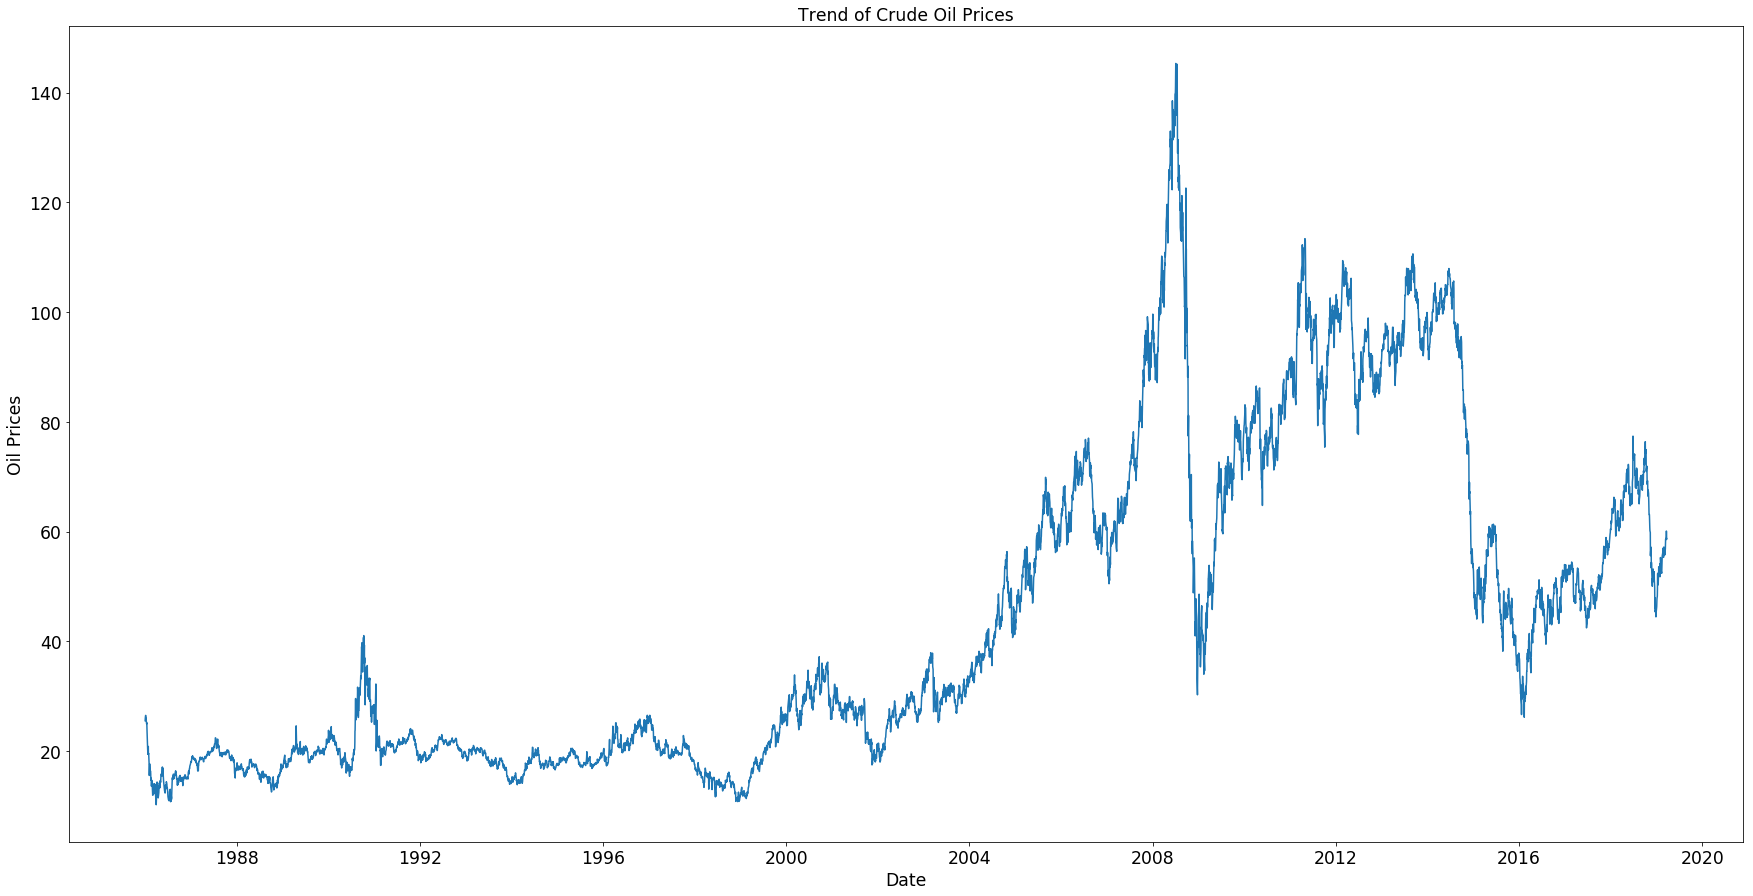

In [5]:
show_graph(oil_prices)

In [6]:
averages, trends = get_moving_window_dataframes(oil_prices, MOVING_AVERAGE_WINDOW_SIZE)

In [7]:
averages.head()

,DCOILWTICO
0,21.224667
1,20.920333
2,20.588000
3,20.193667
4,19.834667


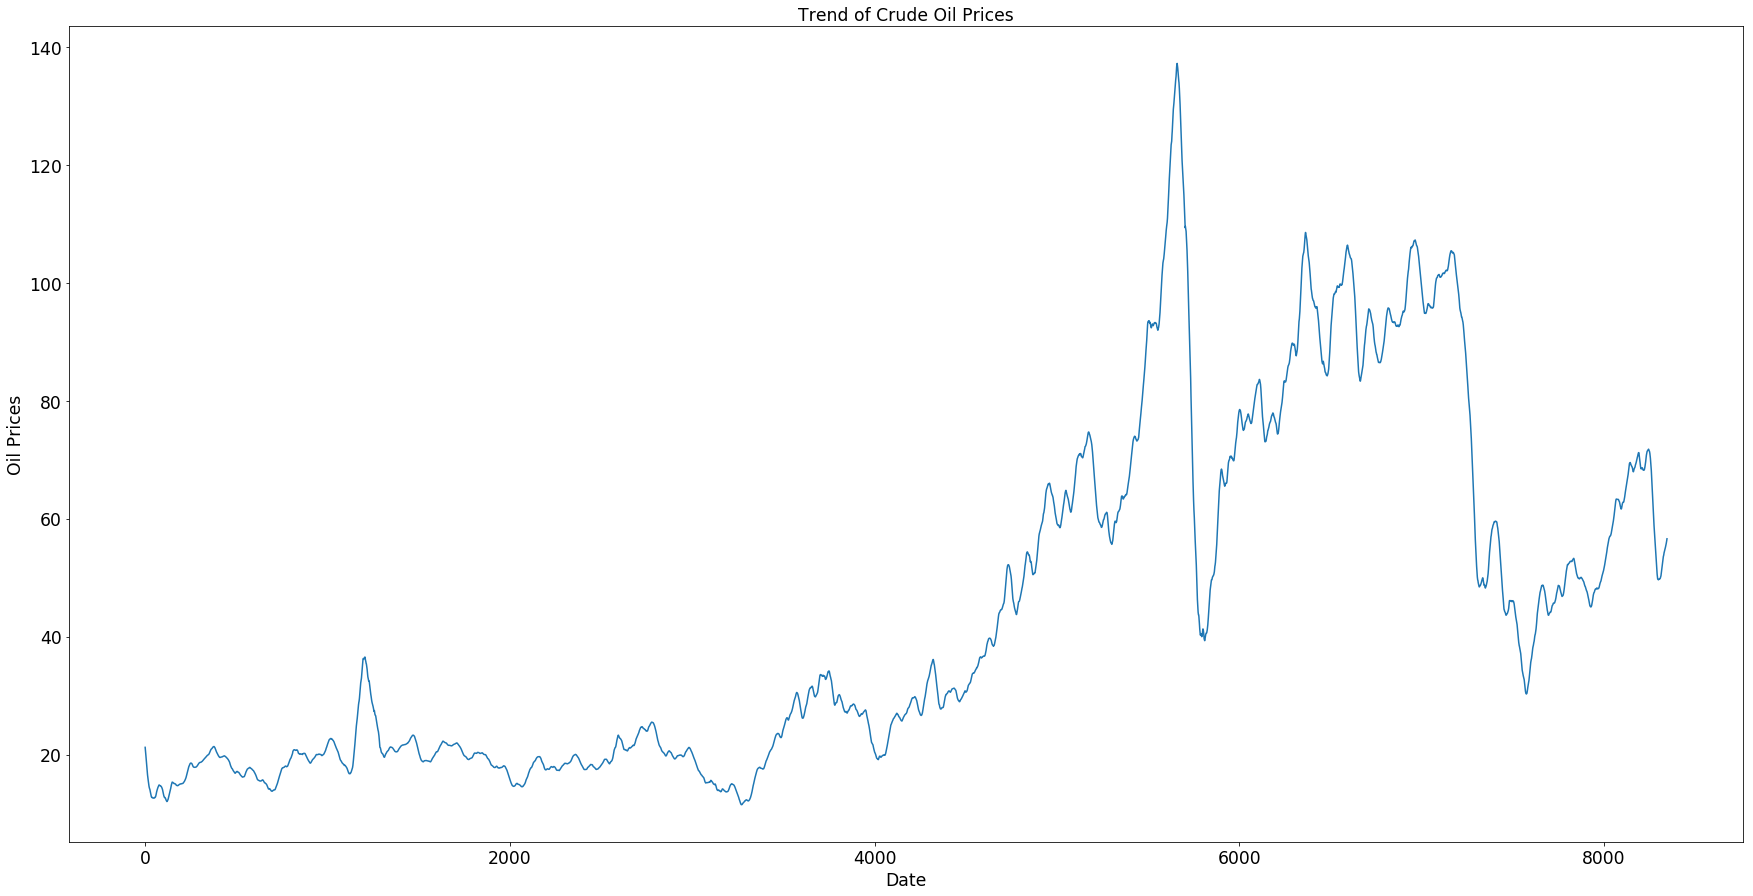

In [8]:
show_graph(averages)

# Hidden Markov Model

In [9]:
recent_trends = trends[-3000:].as_matrix().astype(int)
remodel = hmm.MultinomialHMM(n_components=5, n_iter=200)
remodel.fit(recent_trends[:2000])
test_set = recent_trends[2000:]
predictions = remodel.predict(test_set)
accuracy = (predictions == test_set.flatten()).sum() * 100 / len(predictions)
'Accuracy for Hidden Markov Model is {}%.'.format(accuracy)

/home/sean/.local/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


'Accuracy for Hidden Markov Model is 45.9%.'

In [10]:
scaler = MinMaxScaler(feature_range=(0,1))
matrix = scaler.fit_transform(averages[-3000:])
matrix_train = matrix[:2000]
matrix_test = matrix[2000:]
x_train, y_train, x_test, y_test = generate_train_test_prediction_windows(matrix_train, matrix_test, PREDICTION_WINDOW_SIZE)

# RNN Model

In [11]:
rnn_model, rnn_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'rnn')

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/100
1950/1950 [==============================] - 2s 1ms/step - loss: 0.4867
Epoch 2/100
1950/1950 [==============================] - 2s 818us/step - loss: 0.2635
Epoch 3/100
1950/1950 [==============================] - 2s 813us/step - loss: 0.1692
Epoch 4/100
1950/1950 [==============================] - 2s 891us/step - loss: 0.1114
Epoch 5/100
1950/1950 [==============================] - 2s 903us/step - loss: 0.0652
Epoch 6/100
1950/1950 [==============================] - 2s 787us/step - loss: 0.0401
Epoch 7/100
1950/1950 [==============================] - 2s 807us/step - loss: 0.0221
Epoch 8/100
1950/1950 [==============================] - 2s 785us/step - loss: 0.0149
Epoch 9/100
1950/1950 [==============================] - 2s 786us/step - loss: 

1950/1950 [==============================] - 2s 1ms/step - loss: 6.0561e-04
Epoch 84/100
1950/1950 [==============================] - 2s 1ms/step - loss: 6.6372e-04
Epoch 85/100
1950/1950 [==============================] - 2s 1ms/step - loss: 6.1943e-04
Epoch 86/100
1950/1950 [==============================] - 2s 1ms/step - loss: 6.2514e-04
Epoch 87/100
1950/1950 [==============================] - 2s 1ms/step - loss: 5.6284e-04
Epoch 88/100
1950/1950 [==============================] - 2s 1ms/step - loss: 6.3435e-04
Epoch 89/100
1950/1950 [==============================] - 2s 1ms/step - loss: 8.5861e-04
Epoch 90/100
1950/1950 [==============================] - 2s 1ms/step - loss: 6.4915e-04
Epoch 91/100
1950/1950 [==============================] - 2s 1ms/step - loss: 7.0740e-04
Epoch 92/100
1950/1950 [==============================] - 2s 1ms/step - loss: 5.3944e-04
Epoch 93/100
1950/1950 [==============================] - 2s 1ms/step - loss: 5.9827e-04
Epoch 94/100
1950/1950 [==========

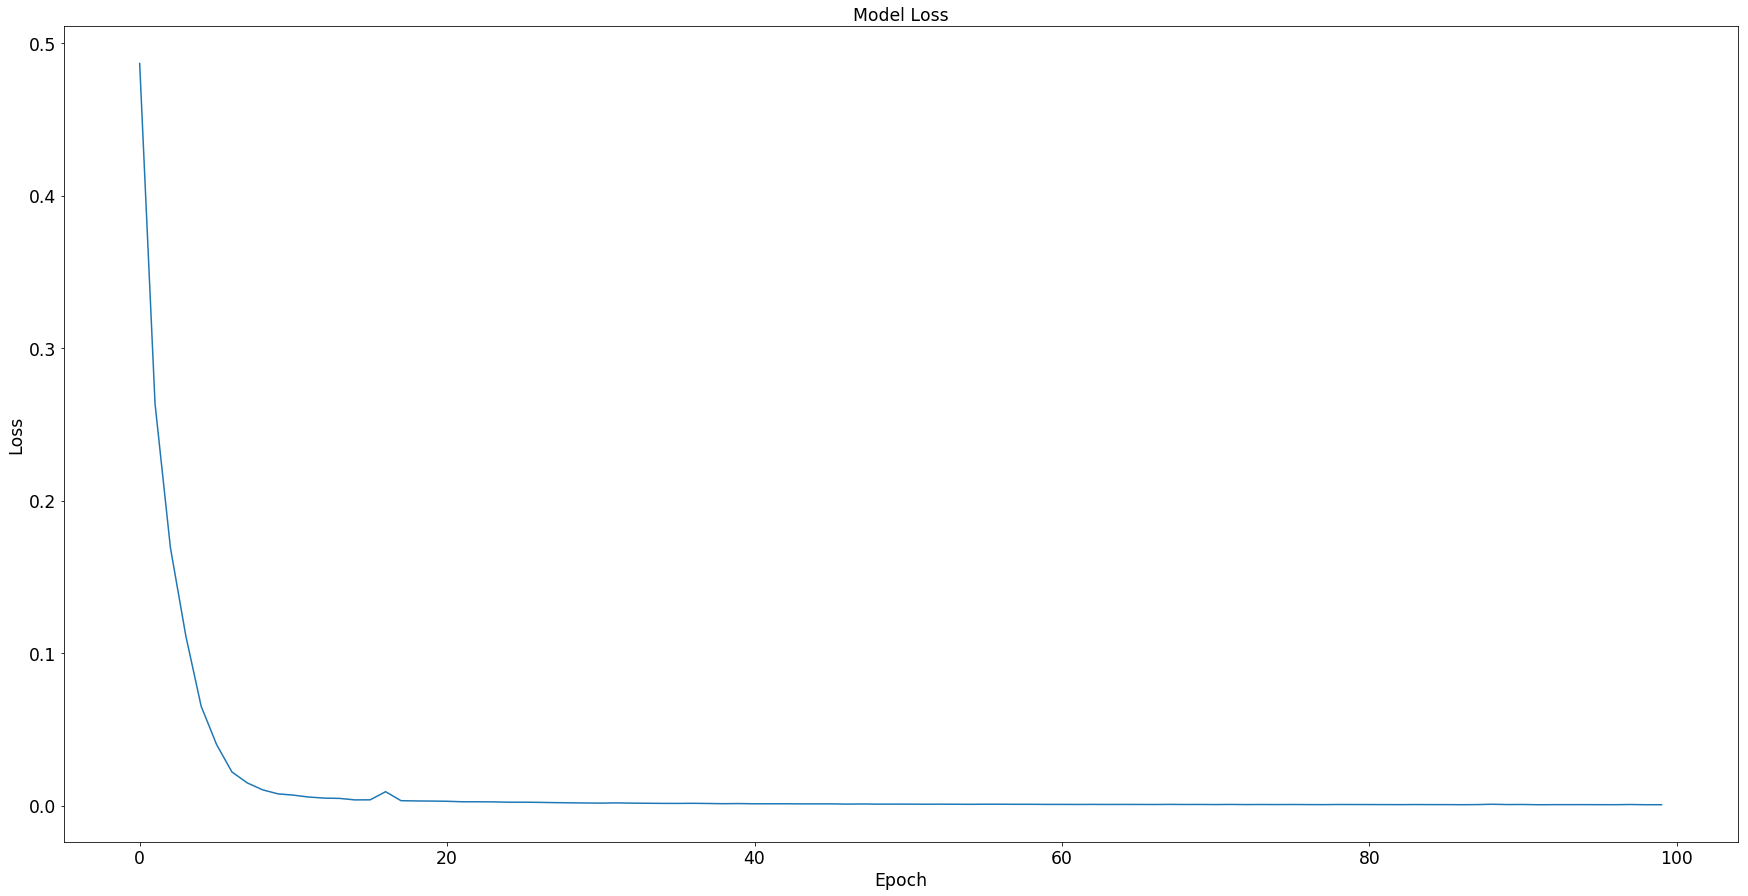

In [12]:
plot_loss(rnn_history)

# LSTM Model

In [13]:
lstm_model, lstm_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'lstm')

Epoch 1/100
1950/1950 [==============================] - 12s 6ms/step - loss: 0.0279
Epoch 2/100
1950/1950 [==============================] - 9s 4ms/step - loss: 0.0105
Epoch 3/100
1950/1950 [==============================] - 9s 4ms/step - loss: 0.0084
Epoch 4/100
1950/1950 [==============================] - 9s 4ms/step - loss: 0.0063
Epoch 5/100
1950/1950 [==============================] - 9s 4ms/step - loss: 0.0057
Epoch 6/100
1950/1950 [==============================] - 9s 4ms/step - loss: 0.0052
Epoch 7/100
1950/1950 [==============================] - 9s 4ms/step - loss: 0.0044
Epoch 8/100
1950/1950 [==============================] - 9s 4ms/step - loss: 0.0042
Epoch 9/100
1950/1950 [==============================] - 9s 4ms/step - loss: 0.0035
Epoch 10/100
1950/1950 [==============================] - 9s 5ms/step - loss: 0.0034
Epoch 11/100
1950/1950 [==============================] - 9s 4ms/step - loss: 0.0032
Epoch 12/100
1950/1950 [==============================] - 9s 4ms/step - l

1950/1950 [==============================] - 9s 5ms/step - loss: 4.8774e-04
Epoch 95/100
1950/1950 [==============================] - 9s 5ms/step - loss: 4.7685e-04
Epoch 96/100
1950/1950 [==============================] - 9s 5ms/step - loss: 4.8238e-04
Epoch 97/100
1950/1950 [==============================] - 9s 4ms/step - loss: 4.1732e-04
Epoch 98/100
1950/1950 [==============================] - 9s 4ms/step - loss: 4.3780e-04
Epoch 99/100
1950/1950 [==============================] - 7s 4ms/step - loss: 4.4292e-04
Epoch 100/100
1950/1950 [==============================] - 5s 3ms/step - loss: 4.7793e-04


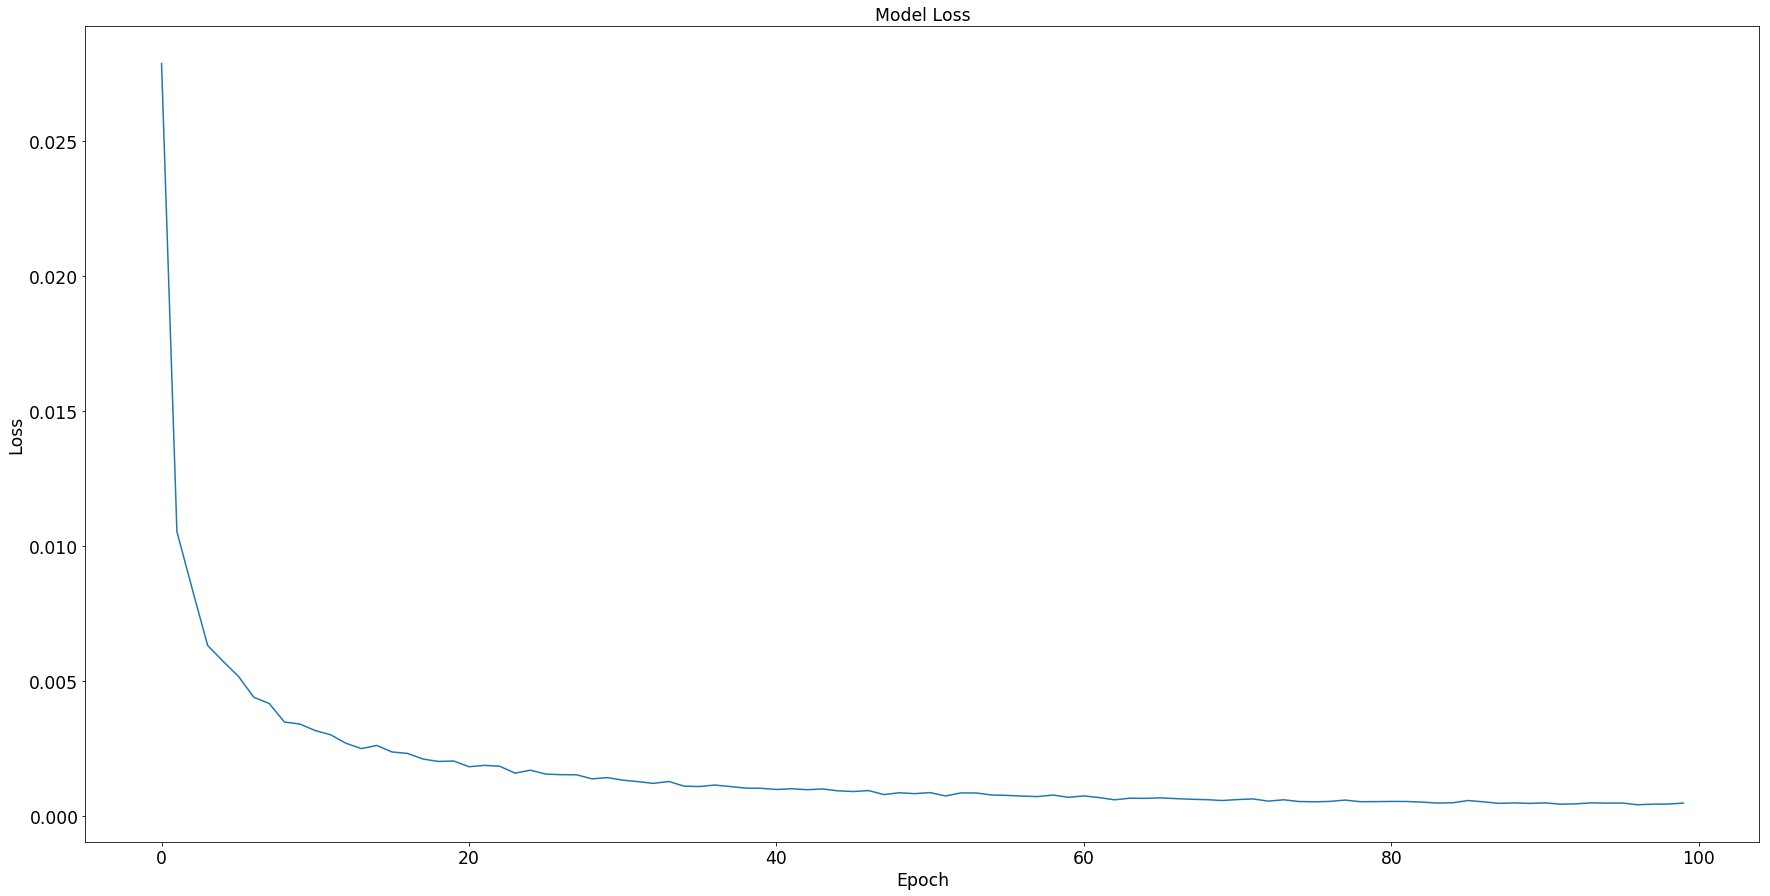

In [14]:
plot_loss(lstm_history)

# GRU Model

In [15]:
gru_model, gru_history = train_model(x_train, y_train, LSTM_UNITS, DROPOUT, NUM_LSTM_LAYERS, 'gru')

Epoch 1/100
1950/1950 [==============================] - 7s 3ms/step - loss: 0.0182
Epoch 2/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0078
Epoch 3/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0070
Epoch 4/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0057
Epoch 5/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0052
Epoch 6/100
1950/1950 [==============================] - 5s 2ms/step - loss: 0.0044
Epoch 7/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0038
Epoch 8/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0040
Epoch 9/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0032
Epoch 10/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0029
Epoch 11/100
1950/1950 [==============================] - 5s 3ms/step - loss: 0.0029
Epoch 12/100
1950/1950 [==============================] - 5s 3ms/step - lo

Epoch 95/100
1950/1950 [==============================] - 5s 3ms/step - loss: 4.2663e-04
Epoch 96/100
1950/1950 [==============================] - 5s 2ms/step - loss: 4.5833e-04
Epoch 97/100
1950/1950 [==============================] - 5s 2ms/step - loss: 4.3486e-04
Epoch 98/100
1950/1950 [==============================] - 5s 2ms/step - loss: 4.1261e-04
Epoch 99/100
1950/1950 [==============================] - 5s 2ms/step - loss: 4.1259e-04
Epoch 100/100
1950/1950 [==============================] - 5s 3ms/step - loss: 4.3734e-04


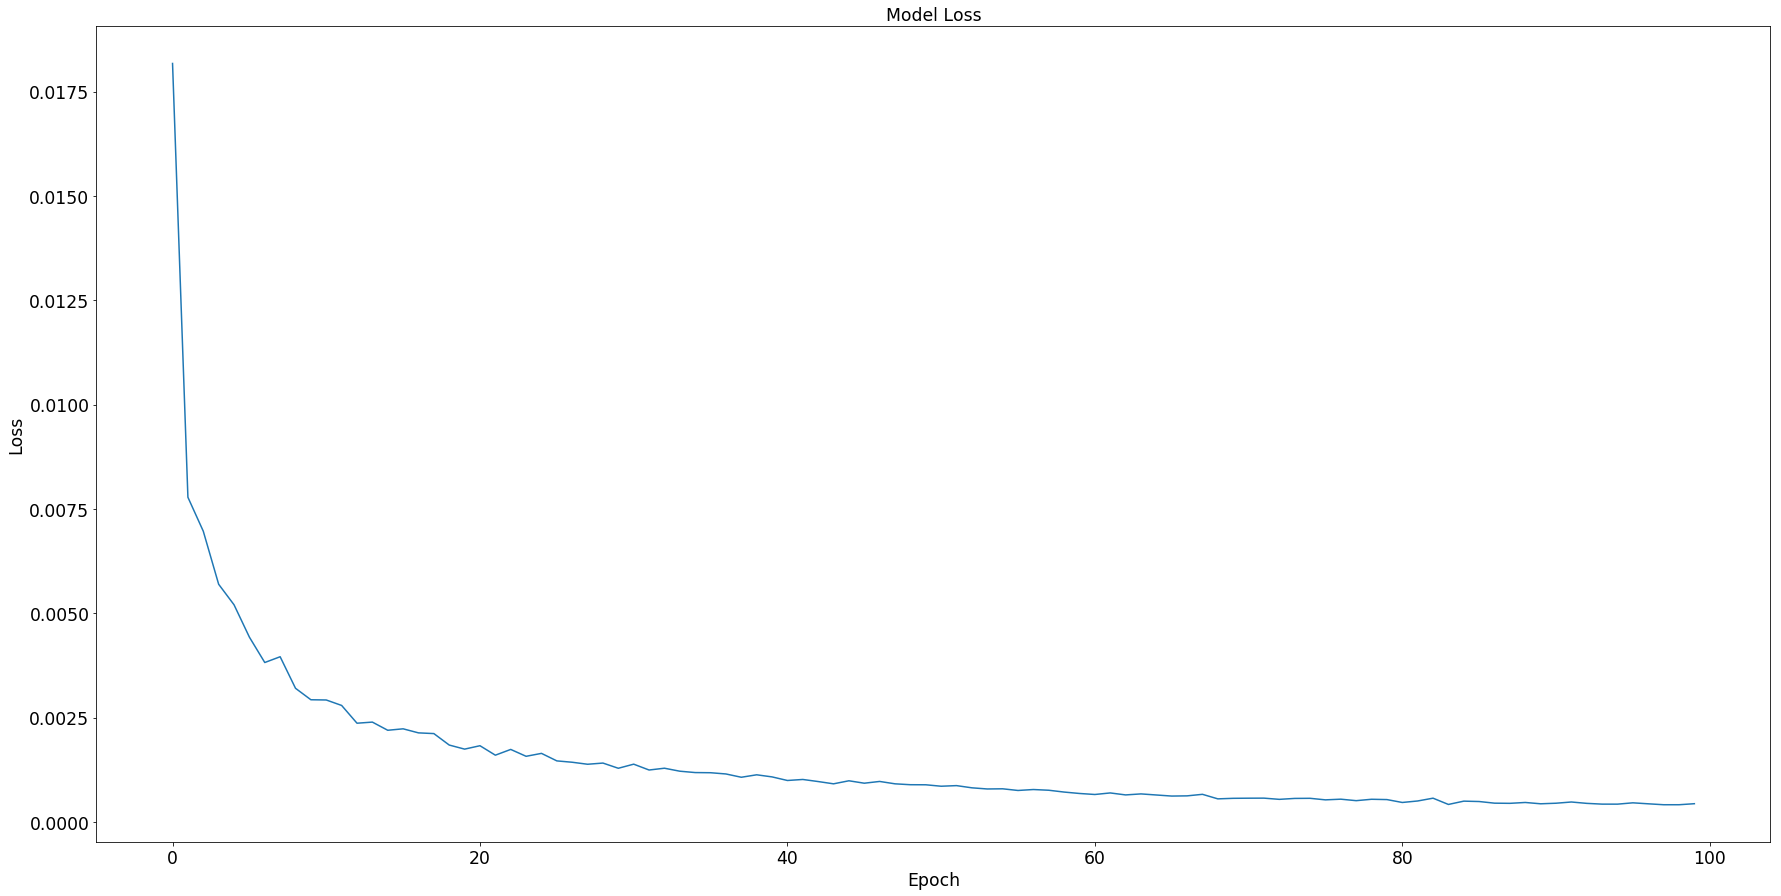

In [16]:
plot_loss(gru_history)

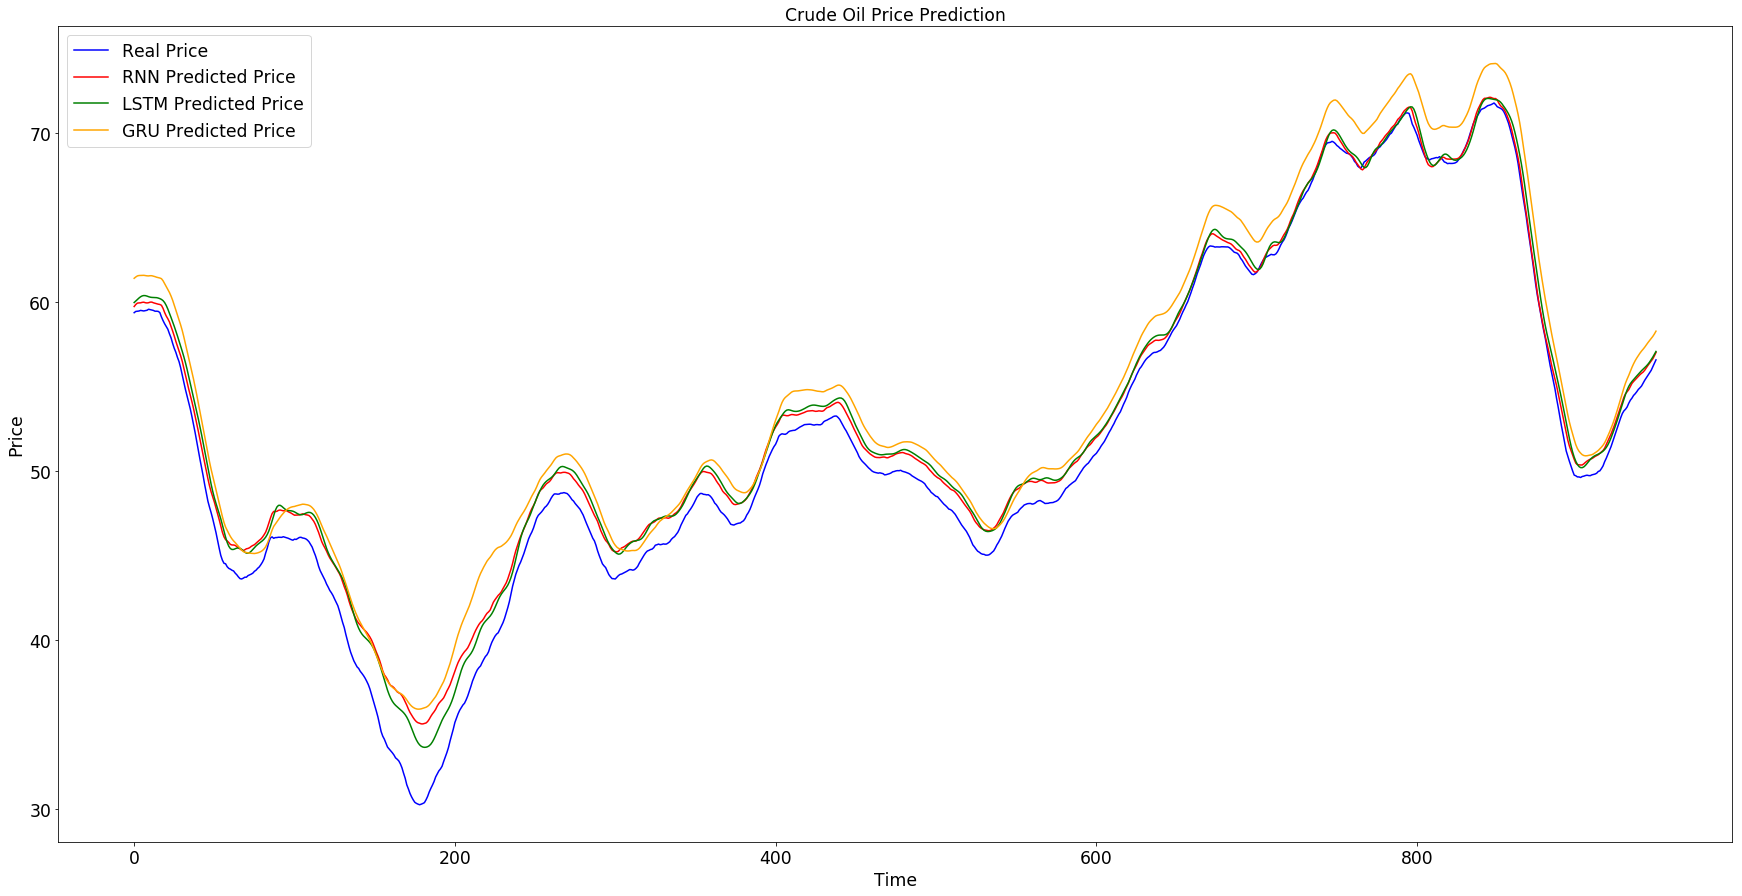

In [17]:
plot_prediction(scaler, x_test, y_test, [('RNN', rnn_model, 'red'), ('LSTM', lstm_model, 'green'), ('GRU', gru_model, 'orange')])

In [18]:
rnn_mse = calculate_mse(x_test, y_test, rnn_model)
print('Mean Square Error for RNN is {}.'.format(rnn_mse))
lstm_mse = calculate_mse(x_test, y_test, lstm_model)
print('Mean Square Error for LSTM is {}.'.format(lstm_mse))
gru_mse = calculate_mse(x_test, y_test, gru_model)
print('Mean Square Error for GRU is {}.'.format(gru_mse))

Mean Square Error for RNN is [0.18604681].
Mean Square Error for LSTM is [0.17031299].
Mean Square Error for GRU is [0.48501128].
